In [18]:
import torch
import os
import torch.nn as nn
import numpy as np
import PIL.Image as im
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from collections import OrderedDict

# Method

This is the development notebook of Vision Transformers. The network processing can be summarized in the following steps:

1. Patchify image: The image I (HxWxC) is divided in N patches of dimension PxPxC. These patches are flattened, which leaves I as Nx(P^2 * C). Each image path acts as a one time step in the sequence of length N.
2. Obtain image embeddings: The patches are linearly projected with a MLP resulting in the patch embedings. These patch embeddings can be seen as the traditional word embeddings in the Transformers.
3. Add class token: A class token with learnable embeddings is introduced as time step 0. This makes the sequence of length N+1. Refer to paper for more information on why this is added.
4. Transformers: The sequence S is injected into a Transformer encoder sequence of blocks. See the development notebook of Transformers for more details.
5. Classification: Finally, the 0th vector of the final layer encoder's output z00 is considered as the image embedding and is introduced in a MLP to obtain the final image classification.

In [56]:
data_path = '/Volumes/Extreme Pro/datasets/CIFAR10'
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [20]:
image_size = 32
patch_size = 4
n_patches = int((image_size**2)/(patch_size**2))

print(n_patches)

64


## 1. Patchify image

In [21]:
def patchify_np(image_np: np.array):
    """ Divide an image into patches of patch_size x path_size x channels """
    n_patches = int((image_size**2)/(patch_size**2))
    length = int(image_size / patch_size)
    patches = []
    for row_idx in range(length):
        row_init = row_idx*patch_size
        for column_idx in range(length):
            column_init = column_idx*patch_size
            patch = image_np[row_init:row_init+patch_size, column_init:column_init+patch_size]
            patches.append(patch)
    assert len(patches) == n_patches
    return patches

class Patchify(nn.Module):
    def __init__(self, h, w, patch_size):
        super(Patchify, self).__init__()
        self.h = h
        self.w = w
        self.patch_size = patch_size

        assert self.h % patch_size == 0, "Image height not divisible by patch height"
        assert self.w % patch_size == 0, "Image width not divisible by patch width"

    def forward(self, image_tensor):

        n_patches = int((self.h*self.w)/(self.patch_size**2))
        length_h = int(self.h / self.patch_size)
        length_w = int(self.w / self.patch_size)
        patches = torch.zeros((n_patches, 3*self.patch_size**2))
        for row_idx in range(length_h):
            row_init = row_idx*patch_size
            for column_idx in range(length_w):
                column_init = column_idx*patch_size
                idx = row_idx*length_h+column_idx
                patch = image_tensor[:, row_init:row_init+patch_size, column_init:column_init+patch_size].flatten()

                patches[idx] = patch  # Insert patch in tensor

        return patches

def unpatchify(patches: list):
    n_patches = len(patches)
    image_r = np.zeros(shape=(32, 32, 3), dtype=np.uint8)
    length = int(image_size / patch_size)
    for row_idx in range(length):
        row_init = row_idx*patch_size
        for column_idx in range(length):
            column_init = column_idx*patch_size
            idx = row_idx*length+column_idx
            image_r[row_init:row_init+patch_size, column_init:column_init+patch_size] = patches[idx]

    return im.fromarray(image_r)


In [22]:
cifar_dataset = CIFAR10(
    data_path,
    train=True,
    download=True,
)

Files already downloaded and verified


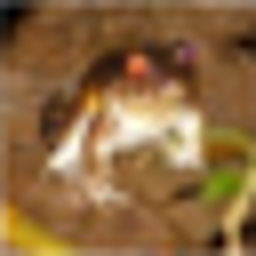

In [23]:
image = cifar_dataset.__getitem__(0)[0]
image.resize((256, 256))

In [24]:
image_np = np.array(image)

image_np.shape

(32, 32, 3)

In [25]:
image_np.shape

(32, 32, 3)

In [26]:
patches = patchify_np(image_np)
patches[8].shape

(4, 4, 3)

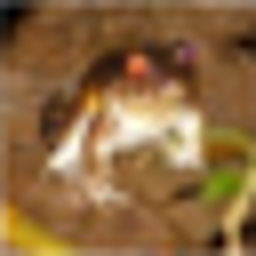

In [27]:
image.resize((256, 256))

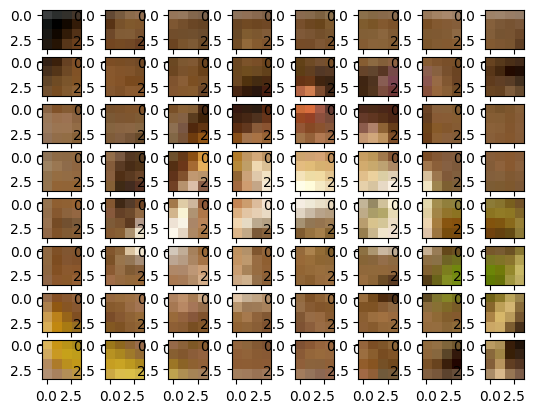

In [28]:
# Check we get the same figure
f, axarr = plt.subplots(8,8)

for row in range(8):
    for column in range(8):
        idx = row*8+column
        axarr[row,column].imshow(patches[idx])

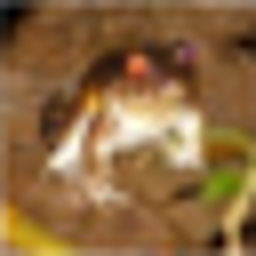

In [29]:
unpatchify(patches).resize((256, 256))

In [30]:
# Flatten patches
f_patches = np.array([patch.flatten() for patch in patches])  # N x (P*P*C)

f_patches = torch.tensor(f_patches, dtype=torch.float)

f_patches.shape

torch.Size([64, 48])

## 2. Obtain patches embeddings and 3. Add the class token embeddings

Be aware of introducing the learnable class token embeddings and position embeddings

In [31]:
transform = transforms.Compose(
[transforms.ToTensor(),
 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
 Patchify(image_size, image_size, patch_size)])

In [32]:
cifar_dataset = CIFAR10(
    data_path,
    train=True,
    transform=transform  # TODO: Implement patchify as a transformation
)

In [33]:
image_tensor = cifar_dataset.__getitem__(0)[0]
print(image_tensor.shape)

torch.Size([64, 48])


In [34]:
out = image_tensor.unsqueeze(0)

out.shape

torch.Size([1, 64, 48])

In [35]:
out.shape, out.mean(), out.var()

(torch.Size([1, 64, 48]), tensor(-0.1886), tensor(0.1662))

In [36]:
d_model = 64
channel_dim = 3
patch_dim = patch_size**2*channel_dim

patch_dim

48

In [37]:
class Projection(nn.Module):
    def __init__(self, n_patches, patch_dim, d_model):
        super(Projection, self).__init__()
        self.n_patches = n_patches
        self.linear = nn.Linear(patch_dim, d_model, bias=False)  # (P*P*C) x D
        self.pos_emb = nn.Embedding(self.n_patches + 1, d_model)  # (N+1, D)
        self.class_embd = nn.Parameter(torch.randn((1, 1, d_model)), requires_grad=True)

    def forward(self, x):
        x = self.linear(x)  # Project patches: Nx(P*P*C) --> BxNxD
        x = torch.cat([self.class_embd, x], dim=1)  # BX(N+1)xD
        pos_idx = torch.arange(start=0, end=self.n_patches+1)  # (0, 1, ..., N)
        x = x + self.pos_emb(pos_idx)  # (N+1)xD

        return x


In [72]:
n_patches, patch_dim, d_model

(64, 4, (64,))

In [71]:
proj = Projection(
    n_patches=n_patches,
    patch_dim=patch_dim,
    d_model=d_model
)

TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [39]:
print(out.shape)

out = proj(out)

torch.Size([1, 64, 48])


In [40]:


out.shape, out.mean(), out.var()

(torch.Size([1, 65, 64]),
 tensor(0.0084, grad_fn=<MeanBackward0>),
 tensor(1.0813, grad_fn=<VarBackward0>))

## 4. Implement Transformers encoder (again)

In [41]:
def attention(q: torch.Tensor, k: torch.Tensor, v: torch.Tensor):
    """ Implement scaled dot-product attention """
    d_k = k.shape[-1]  # D
    scores = torch.softmax(torch.matmul(q, k.transpose(-1, -2)) / d_k, dim=-1)  # NxN
    return torch.bmm(scores, v)  # NxD

class AttentionHead(nn.Module):
    def __init__(self, d_model, d_k):
        super(AttentionHead, self).__init__()
        self.W_k = nn.Linear(d_model, d_k, bias=False)
        self.W_q = nn.Linear(d_model, d_k, bias=False)
        self.W_v = nn.Linear(d_model, d_k, bias=False)


    def forward(self, x):
        return attention(self.W_k(x), self.W_q(x), self.W_v(x))


class MSA(nn.Module):
    """ Implement multi-head self-attention"""
    def __init__(self, n_heads, d_model):
        super(MSA, self).__init__()
        self.n_heads = n_heads
        self.d_k = int(d_model // n_heads)
        self.heads = nn.ModuleList([AttentionHead(d_model, self.d_k) for _ in range(n_heads)])
        self.W_o = nn.Linear(d_model, d_model, bias=False)  # DxD

    def forward(self, x):
        x = torch.cat([head(x) for head in self.heads], dim=-1)
        x = self.W_o(x)

        return x

class FFN(nn.Module):
    def __init__(self, d_model):
        super(FFN, self).__init__()
        self.l1 = nn.Linear(d_model, d_model, bias=True)
        self.l2 = nn.Linear(d_model, d_model, bias=True)


    def forward(self, x):
        x = nn.functional.gelu(self.l1(x))
        return self.l2(x)

class Encoder(nn.Module):

    def __init__(self, n_heads, d_model):
        super(Encoder, self).__init__()
        self.ln1 = nn.LayerNorm(d_model)
        assert d_model % n_heads == 0, f"d_model must be divisible by n_heads but d_model/n_heads = {d_model/n_heads}"
        self.msa = MSA(n_heads, d_model)  # BxNxD
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FFN(d_model)  # BxNxD

    def forward(self, x):
        out = self.msa(self.ln1(x)) + x
        return self.ffn(self.ln2(out)) + out



In [42]:
# Check attention function
attention(out, out, out).var()

tensor(0.0516, grad_fn=<VarBackward0>)

In [43]:
# Check attention head
att_head = AttentionHead(d_model, d_model)

att_head(out).var()

tensor(0.0153, grad_fn=<VarBackward0>)

In [44]:
# Check multi-head self-attention
msa = MSA(4, d_model)

msa(out).var()

tensor(0.0061, grad_fn=<VarBackward0>)

In [45]:
# Check encoder
enc = Encoder(n_heads=4, d_model=d_model)

enc(out).shape, enc(out).mean(), enc(out).var()

(torch.Size([1, 65, 64]),
 tensor(0.0240, grad_fn=<MeanBackward0>),
 tensor(1.1383, grad_fn=<VarBackward0>))

In [46]:
out = enc(out)

In [47]:
out.shape, out.mean(), out.var()

(torch.Size([1, 65, 64]),
 tensor(0.0240, grad_fn=<MeanBackward0>),
 tensor(1.1383, grad_fn=<VarBackward0>))

## 5 Compose the final Vision Transformer by adding the classification head for the 0th vector of the sequence

In [48]:
class ViT(nn.Module):
    def __init__(self, n_patches, patch_dim, n_blocks, n_heads, d_model, n_classes):
        super(ViT, self).__init__()
        # Add hyperparameters for information
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.d_model = d_model
        self.n_classes = n_classes

        ##### Define model #####
        self.projection = Projection(n_patches, patch_dim, d_model)
        # Add n_blocks encoder blocks
        self.encoder_blocks = nn.Sequential(OrderedDict([
            (f'block_{i}', Encoder(n_heads, d_model)) for i in range(n_blocks)
        ]))

        self.mlp = nn.Linear(d_model, n_classes)  # W: DxK

    def forward(self, x):  # BxNx(PPC)
        x = self.projection(x)  # BxNxD
        x = self.encoder_blocks(x)  # BxNxD
        class_token = x[:, 0, :]  # Bx1xD
        print(f'encoder out: {x.shape}')
        print(f'class token: {class_token.shape}')
        return self.mlp(class_token)  # Bx1xK



In [49]:
batch = image_tensor.unsqueeze(0)

batch.shape

torch.Size([1, 64, 48])

In [50]:
model = ViT(
    n_patches=n_patches,
    patch_dim=patch_dim,
    n_blocks=4,
    n_heads=4,
    d_model=d_model,
    n_classes = 10
)

In [51]:
logits = model(batch)

logits.shape, logits.mean(), logits.var()

encoder out: torch.Size([1, 65, 64])
class token: torch.Size([1, 64])


(torch.Size([1, 10]),
 tensor(-0.1069, grad_fn=<MeanBackward0>),
 tensor(1.1844, grad_fn=<VarBackward0>))

In [52]:
probs = logits.softmax(dim=1)

probs

tensor([[0.0232, 0.0134, 0.0181, 0.0894, 0.0621, 0.0955, 0.4485, 0.0797, 0.1458,
         0.0244]], grad_fn=<SoftmaxBackward0>)

In [53]:
probs.std()

tensor(0.1297, grad_fn=<StdBackward0>)

In [54]:
## Comprueba que a la inicialización las probabilidades estén los suficientemente dispersas. Basta con comprobar que la negative log likelihood
# de un batch es igual a -log(1/C) o log(C) y será la confirmación de que la red está bien inicializada

## Define the training loop

In [82]:
if torch.cuda.is_available():
    device = 'cuda:0'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f'Using {device} device')

Using mps device


In [77]:
# Define hyperparameters
epochs = 10
batch_size = 32

patch_dim=4
n_blocks=4
n_heads=4
d_model=64
n_classes = 10

In [78]:
# Create the dataset and dataloader
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     Patchify(image_size, image_size, patch_size)])

train_set = CIFAR10(
    data_path,
    train=True,
    transform=transform 
)

test_set = CIFAR10(
    data_path,
    train=False,
    transform=transform
)

trainloader = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True
)

testloader = DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=False
)

In [84]:
# Define model
model = ViT(
    n_patches=n_patches, 
    patch_dim=patch_dim,
    n_blocks=n_blocks, 
    n_heads=n_heads, 
    d_model=d_model, 
    n_classes=10
)

model.to(device)  # Send model to device

n_paramters = sum(parameters.numel() for parameters in model.parameters())  # Count the number of parameters

n_paramters

104970

In [63]:
for epoch in range(epochs):
    for idx, data in enumerate(trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)
        print(f'x.shape: {x.shape}')
        print(f'y.shape: {y.shape}')
        
        
        
        
        break
        
    break
        

x.shape: torch.Size([32, 64, 48])
y.shape: torch.Size([32])
